# Stratification introduction

So far we've looked at how to create a compartmental model, add flows, request derived outputs and use different solvers. Now we'll look into stratifying a model using the [Stratification](http://summerepi.com/api/stratification.html) class.

Consider the following scenario, you are modelling some infectious disease that has different susceptibility and infection mortality across different age groups. We can use stratifications to model this.

In this example we'll cover:

- [No stratification](#No-stratification)
- [Minimal stratification](#Minimal-stratification)
- [Population distribution](#Population-distribution)
- [Flow adjustments](#Flow-adjustments)
- [Infectiousness adjustments](#Infectiousness-adjustments)
- [Partial stratifications](#Partial-stratifications)
- [Multiple stratifications](#Multiple-stratifications)
- [Multiple interdependent stratifications](#Multiple-interdependent-stratifications)

First, let's import the summer library and create a new [CompartmentalModel](/api/model.html) with S, I, R compartments plus infection, death and recovery flows. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from summer import CompartmentalModel

def build_model():
    """Returns a model for the stratification examples"""
    model = CompartmentalModel(
        times=[0, 20],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )

    # Add people to the model
    model.set_initial_population(distribution={"S": 990, "I": 10})

    # Susceptible people can get infected.
    model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")

    # Infectious people take 3 years, on average, to recover.
    model.add_transition_flow(name="recovery", fractional_rate=1/3, source="I", dest="R")

    # Add an infection-specific death flow to the I compartment.
    model.add_death_flow(name="infection_death", death_rate=0.05, source="I")
    return model

    
def plot_compartments(model, times=[]):
    """Plot model compartment sizes over time"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
    for i in range(model.outputs.shape[1]):
        ax.plot(model.times, model.outputs.T[i])

    for t in times:
        ax.axvline(x=t, color='k', linestyle='--', alpha=0.3)
        
    ax.set_title("SIR Model Outputs")
    ax.set_xlabel("Days")
    ax.set_ylabel("Compartment size")
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
    ax.legend([str(c) for c in model.compartments], loc='center right')
    plt.show()
    print("Compartment names:", model.compartments)
    print("Initial values:", model.outputs[0])
    print('Final values:', model.outputs[-1])

# Force NumPy to format output arrays nicely. 
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

## No stratification

With no stratification, this is just a regular SIR model: there are 3 compartments where susceptible people get infected/infectious, some of them die, and some of them recover.

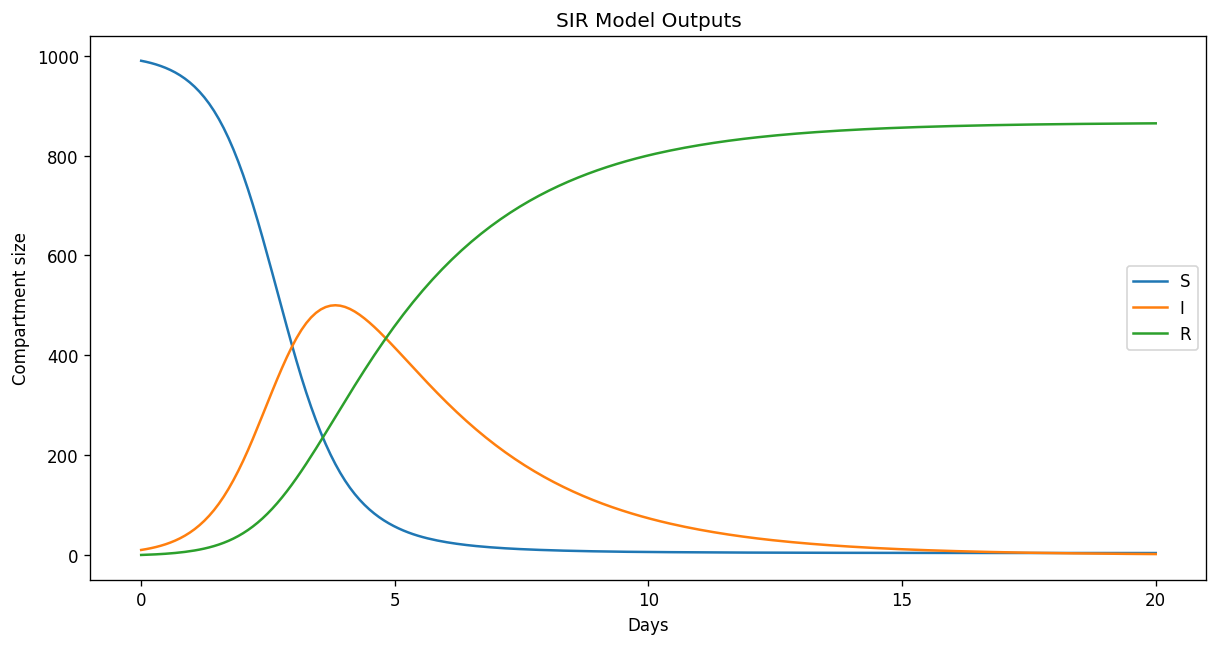

Compartment names: [S, I, R]
Initial values: [990.00 10.00 0.00]
Final values: [3.87 1.76 864.67]


In [2]:
# Build and run model with no stratifications
model = build_model()
model.run()
plot_compartments(model)

## Minimal stratification

Next, let's try a simple stratification where we split the population into 'young' (say, 0 to 39 years old) and 'old' (aged 40 and above). Notice the following changes to the model outputs:

- There are now 6 compartments instead of 3: each original compartment has been split into an "old" and "young" compartment, with the original population evenly divided between them (by default)
- The model dynamics haven't changed otherwise: we will get the same results as before if we add the old and young compartments back together. This is because there is homogeneous mixing between strata and no demographic processes, etc.

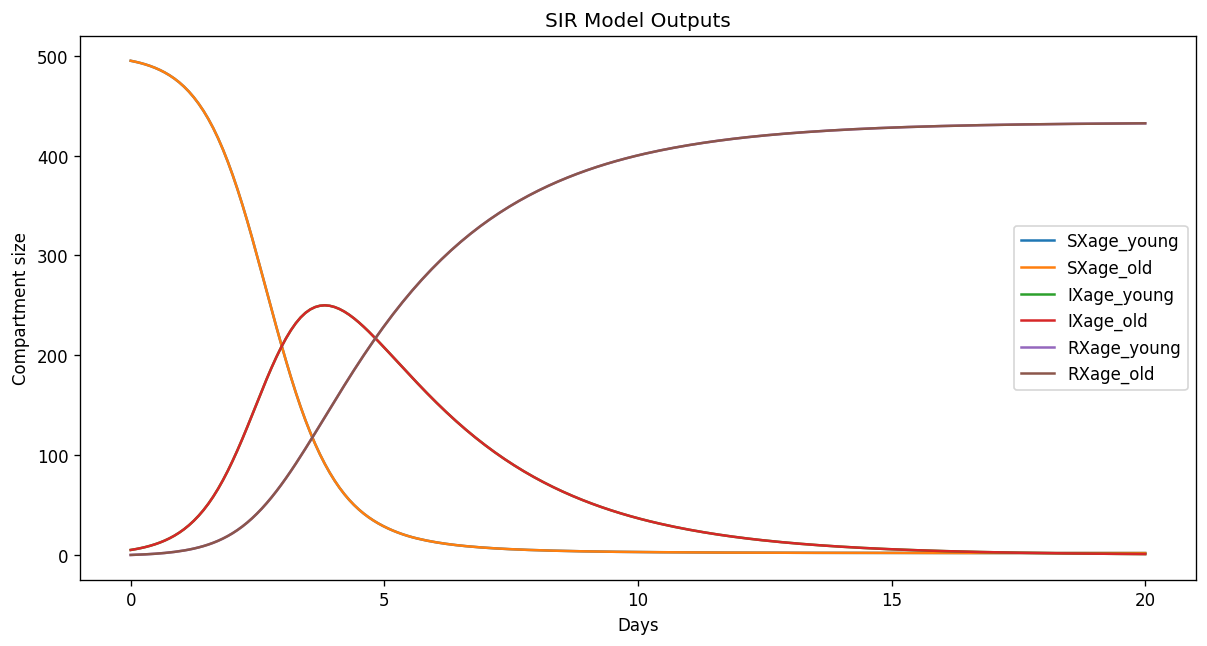

Compartment names: [SXage_young, SXage_old, IXage_young, IXage_old, RXage_young, RXage_old]
Initial values: [495.00 495.00 5.00 5.00 0.00 0.00]
Final values: [1.90 1.90 0.88 0.88 432.36 432.36]


In [3]:
from summer import Stratification

# Create a stratification named 'age', applying to all compartments, which
# splits the population into 'young' and 'old'.
strata = ["young", "old"]
strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

## Population distribution

We may not always wish to split the population evenly between strata. For example, we might know that 60% of the population is 'young' while 40% is 'old'. Notice that

- The stratified compartments are now split according to a 60:40 ratio into young and old respectively
- The overall model dynamics still haven't changed otherwise

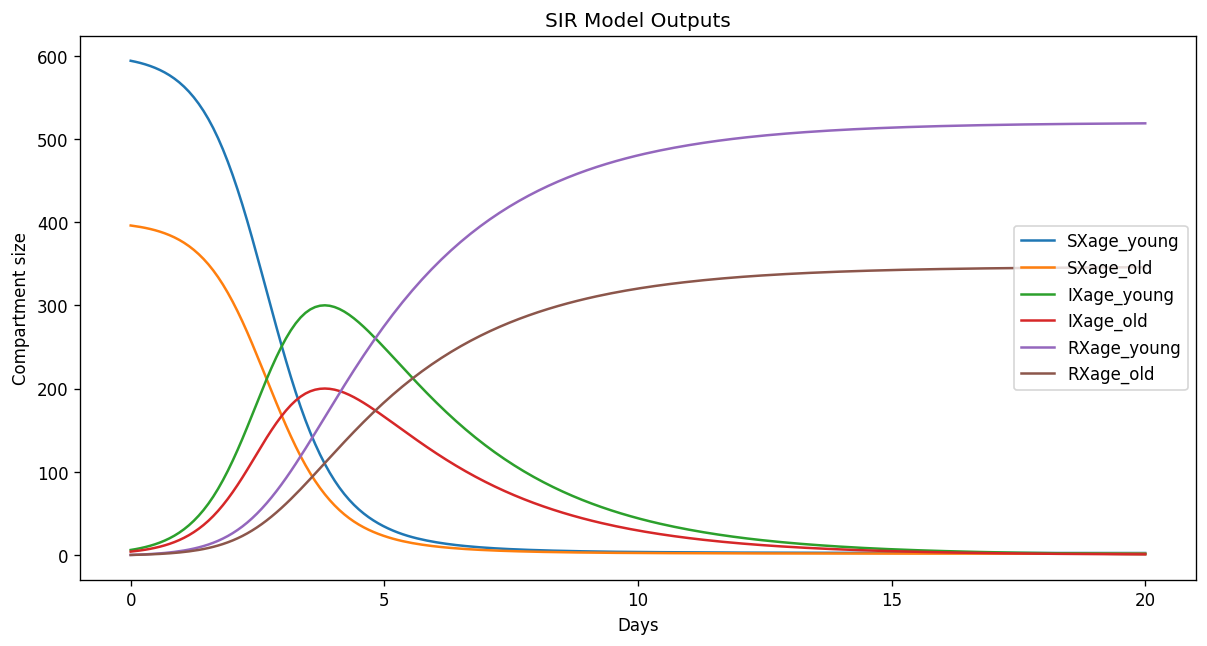

Compartment names: [SXage_young, SXage_old, IXage_young, IXage_old, RXage_young, RXage_old]
Initial values: [594.00 396.00 6.00 4.00 0.00 0.00]
Final values: [2.32 1.55 1.06 0.70 518.80 345.87]


In [4]:
from summer import Stratification

# Create a stratification named 'age', applying to all compartments, which
# splits the population into 'young' and 'old'.
strata = ["young", "old"]
strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])

# Set a population distribution
strat.set_population_split({"young": 0.6, "old": 0.4})

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

## Flow adjustments

As noted so far, we've been successful in subdividing the population, but haven't actually changed our model dynamics, which is kind of boring. Next let's look at how we can adjust the flow rates based on strata. Let's assume two new facts about our disease:

- young people are twice as susceptible to infection
- old people are three times as likely to die from the infectious disease, while younger people are half as likely as under the original parameters we requested
- younger people take twice as long to recover

These inter-strata differences can be modelled using flow adjustments. Now we're seeing some genuinely new model dynamics. Note how there are fewer recovered 'old' people at the end of the model run, because of their higher death rate.

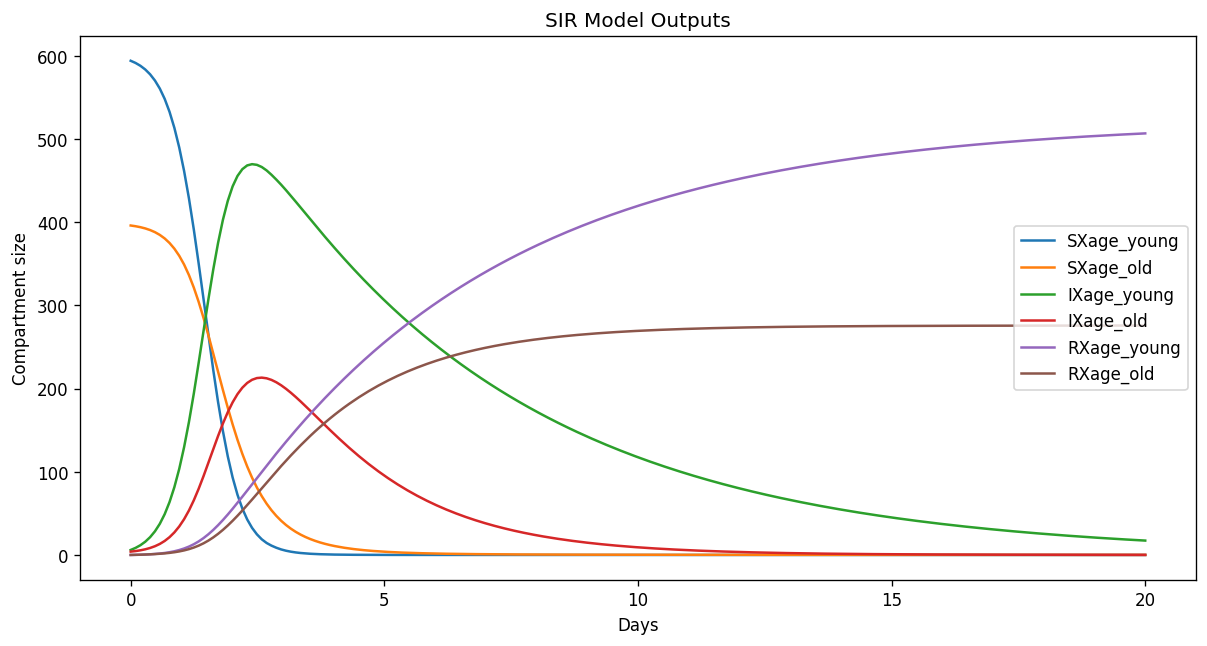

Compartment names: [SXage_young, SXage_old, IXage_young, IXage_old, RXage_young, RXage_old]
Initial values: [594.00 396.00 6.00 4.00 0.00 0.00]
Final values: [0.00 0.06 17.28 0.08 506.72 275.76]


In [5]:
from summer import Stratification, Multiply

# Create a stratification named 'age', applying to all compartments, which
# splits the population into 'young' and 'old'.
strata = ["young", "old"]
strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])

# Set a population distribution
strat.set_population_split({"young": 0.6, "old": 0.4})

# Add an adjustment to the 'infection' flow
strat.add_flow_adjustments("infection", {
    "old": None,  # No adjustment for old people, use baseline requested value
    "young": Multiply(2),  # Young people are twice twice as susceptible to infection
})

# Add an adjustment to the 'infection_death' flow
strat.add_flow_adjustments("infection_death", {
    "old": Multiply(3),  # Older people die at three times the rate requested under the original parameters
    "young": Multiply(0.5), # Younger people die at half the rate requested under the original parameters
})

# Add an adjustment to the 'recovery' flow
strat.add_flow_adjustments("recovery", {
    "old": None,  # No adjustment for old people, use baseline
    "young": Multiply(0.5),  # Young people take twice as long to recover
})

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

## Infectiousness adjustments

In addition to adjusting flow rates for each strata, you can also set an infectiousness level for a given strata. This affects how likely an infectious person in that stratum is to infect someone else. For example we could consider the following:

- young people are 1.2 times as infectious, because they're not wearing face masks as much
- young people are twice as susceptible to the disease, because some of them have immature immune systems


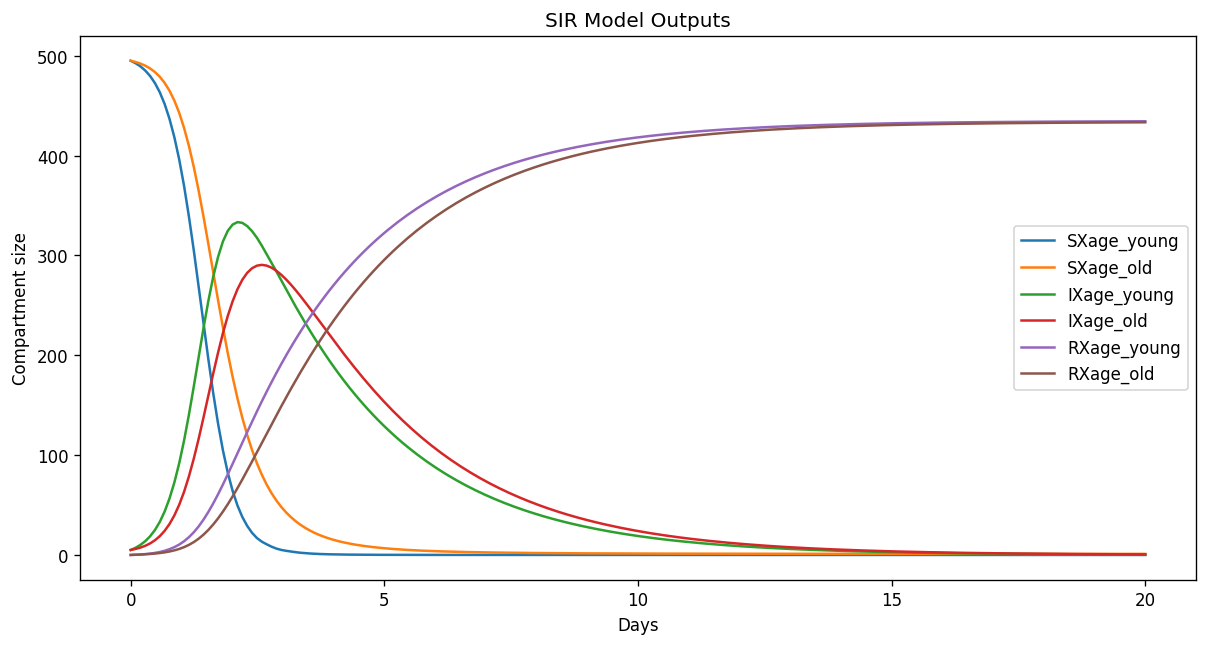

Compartment names: [SXage_young, SXage_old, IXage_young, IXage_old, RXage_young, RXage_old]
Initial values: [495.00 495.00 5.00 5.00 0.00 0.00]
Final values: [0.00 1.07 0.41 0.55 434.42 433.37]


In [6]:
from summer import Stratification, Multiply, Overwrite

# Create a stratification named 'age', applying to all compartments, which
# splits the population into 'young' and 'old'.
strata = ["young", "old"]
strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])

# Set a population distribution
strat.set_population_split({"young": 0.5, "old": 0.5})

# Add an adjustment to the 'infection' flow
strat.add_flow_adjustments("infection", {
    "old": None,  # No adjustment for old people, use baseline
    "young": Multiply(2),  # Young people twice as susceptible
})

# Add an adjustment to infectiousness levels for young people in the 'I' compartment
strat.add_infectiousness_adjustments("I", {
    "old": None,  # No adjustment for old people, use baseline
    "young": Multiply(1.2),  # Young people 5x more infectious
})

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

## Partial stratifications

So far we've been stratifying all compartments, but Summer allows only some of the compartments to be stratified. For example, we can stratify only the infectious compartment to model three different levels of disease severity: asymptomatic, mild and severe.

When you do a partial stratification, flow rates into that stratified compartment will automatically be adjusted with an even split to conserve the behaviour by default, e.g. a flow rate of 3 from a source will be evenly split into (1, 1, 1) across the three destinations. This behaviour can be manually overriden with a flow adjustment.

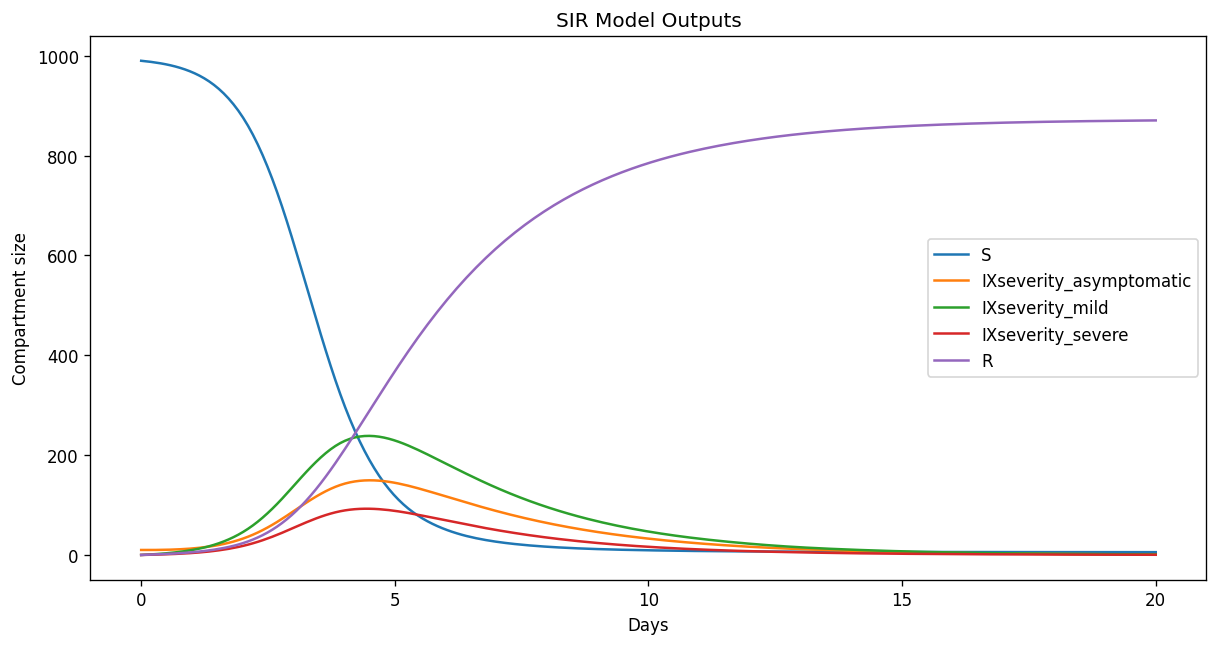

Compartment names: [S, IXseverity_asymptomatic, IXseverity_mild, IXseverity_severe, R]
Initial values: [990.00 10.00 0.00 0.00 0.00]
Final values: [5.61 1.01 1.12 0.38 870.51]


In [7]:
from summer import Stratification, Multiply, Overwrite

# Create a stratification named 'severity', applying to the infectious, which
# splits that compartment into 'asymptomatic', 'mild' and 'severe'.
strata = ["asymptomatic", "mild", "severe"]
strat = Stratification(name="severity", strata=strata, compartments=['I'])

# Set a population distribution - everyone starts out asymptomatic.
strat.set_population_split({"asymptomatic": 1.0, "mild": 0, "severe": 0})

# Add an adjustment to the 'infection' flow, overriding default split.
strat.add_flow_adjustments("infection", {
    "asymptomatic": Multiply(0.3),  # 30% of incident cases are asymptomatic
    "mild": Multiply(0.5),  # 50% of incident cases are mild
    "severe": Multiply(0.2),  # 20% of incident cases are severe
})

# Add an adjustment to the 'infection_death' flow
strat.add_flow_adjustments("infection_death", {
    "asymptomatic": Multiply(0.5),
    "mild": None,
    "severe": Multiply(1.5),
})

strat.add_infectiousness_adjustments("I", {
    "asymptomatic": Multiply(0.5),
    "mild": None,
    "severe": Multiply(1.5),
})

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

## Multiple stratifications

A model can have multiple stratifications applied in series. For example, we can add an 'age' stratification, followed by a 'severity' one.

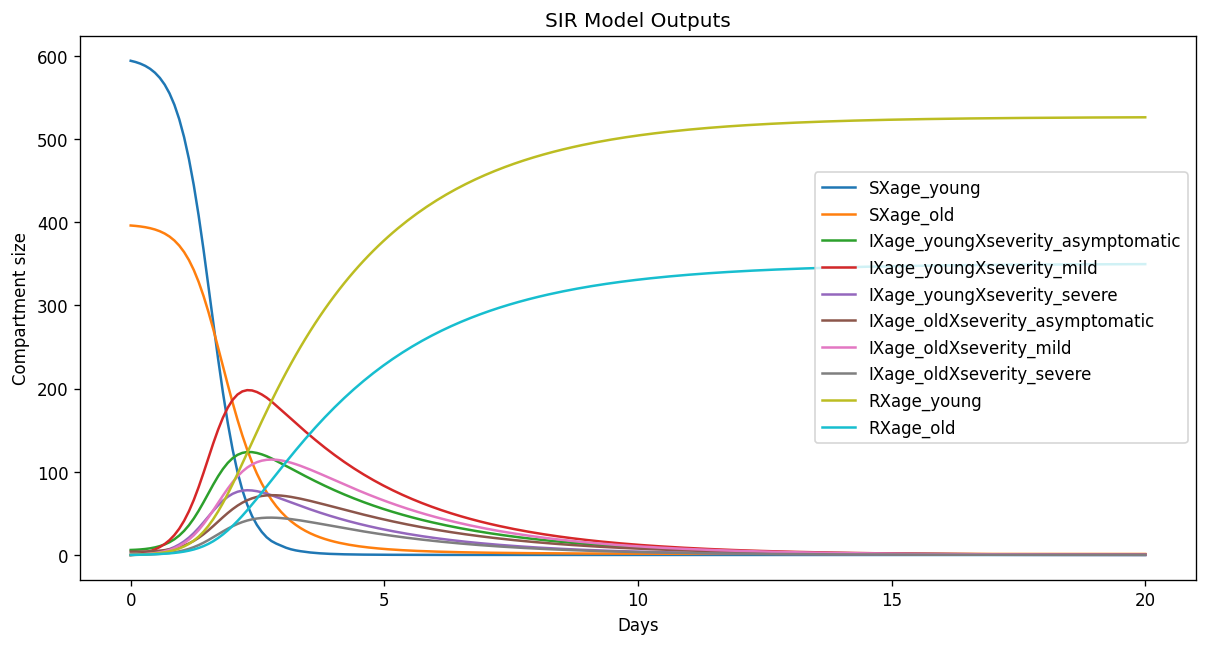

Compartment names: [SXage_young, SXage_old, IXage_youngXseverity_asymptomatic, IXage_youngXseverity_mild, IXage_youngXseverity_severe, IXage_oldXseverity_asymptomatic, IXage_oldXseverity_mild, IXage_oldXseverity_severe, RXage_young, RXage_old]
Initial values: [594.00 396.00 6.00 0.00 0.00 4.00 0.00 0.00 0.00 0.00]
Final values: [0.01 1.16 0.26 0.27 0.07 0.22 0.24 0.06 526.06 349.57]


In [8]:
from summer import Stratification, Multiply, Overwrite

### Age stratification

# Create a stratification named 'age', applying to all compartments,
# which splits the population into 'young' and 'old'.
strata = ["young", "old"]
age_strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])
age_strat.set_population_split({"young": 0.6, "old": 0.4})

# Add an adjustment to the 'infection' flow
age_strat.add_flow_adjustments("infection", {
    "old": None,  # No adjustment for old people, use unstratified parameter value
    "young": Multiply(2),  # Young people are twice as susceptible
})

# Add an adjustment to infectiousness levels for young people the 'I' compartment
age_strat.add_infectiousness_adjustments("I", {
    "old": None,  # No adjustment for old people, use unstratified parameter value
    "young": Multiply(1.2),  # Young people are 5x more infectious
})


### Disease severity stratification

# Create a stratification named 'severity', applying to the infectious compartment, which
# splits that compartment into 'asymptomatic', 'mild' and 'severe'.
strata = ["asymptomatic", "mild", "severe"]
severity_strat = Stratification(name="severity", strata=strata, compartments=["I"])
severity_strat.set_population_split({"asymptomatic": 1.0, "mild": 0, "severe": 0})

# Add an adjustment to the 'infection' flow (overriding the default split of one third to each stratum)
severity_strat.add_flow_adjustments("infection", {
    "asymptomatic": Multiply(0.3),  # 30% of cases are asympt.
    "mild": Multiply(0.5),  # 50% of cases are mild.
    "severe": Multiply(0.2),  # 20% of cases are severse.
})

# Add an adjustment to the 'infection_death' flow
severity_strat.add_flow_adjustments("infection_death", {
    "asymptomatic": Multiply(0.5),
    "mild": None,
    "severe": Multiply(1.5),
})

severity_strat.add_infectiousness_adjustments("I", {
    "asymptomatic": Multiply(0.5),
    "mild": None,
    "severe": Multiply(1.5),
})


# Build and run model with the stratifications we just defined
model = build_model()
# Apply age, then severity stratifications 
model.stratify_with(age_strat)
model.stratify_with(severity_strat)
model.run()
plot_compartments(model)

## Multiple interdependent stratifications

In the previous example we assumed that the age and severity stratifications were independent. For example, we assumed that the proportion of infected people who have a disease severity of asymptomatic, mild and severe is the same for both young and old people. Perhaps, for a given disease, this is not true! it's easy to imagine an infection for which younger people tend towards being more asymptomatic, and older people tend towards having a more severe infection.

This interdependency between stratifications can be modelled using Summer, where a flow adjustment for a stratification can selectively refer to strata used for previous stratifications. You can refer to the API reference for [add_flow_adjustments](http://summerepi.com/api/stratification.html#summer.stratification.Stratification.add_flow_adjustments) for more details.

To clarify, let's consider the example described above:

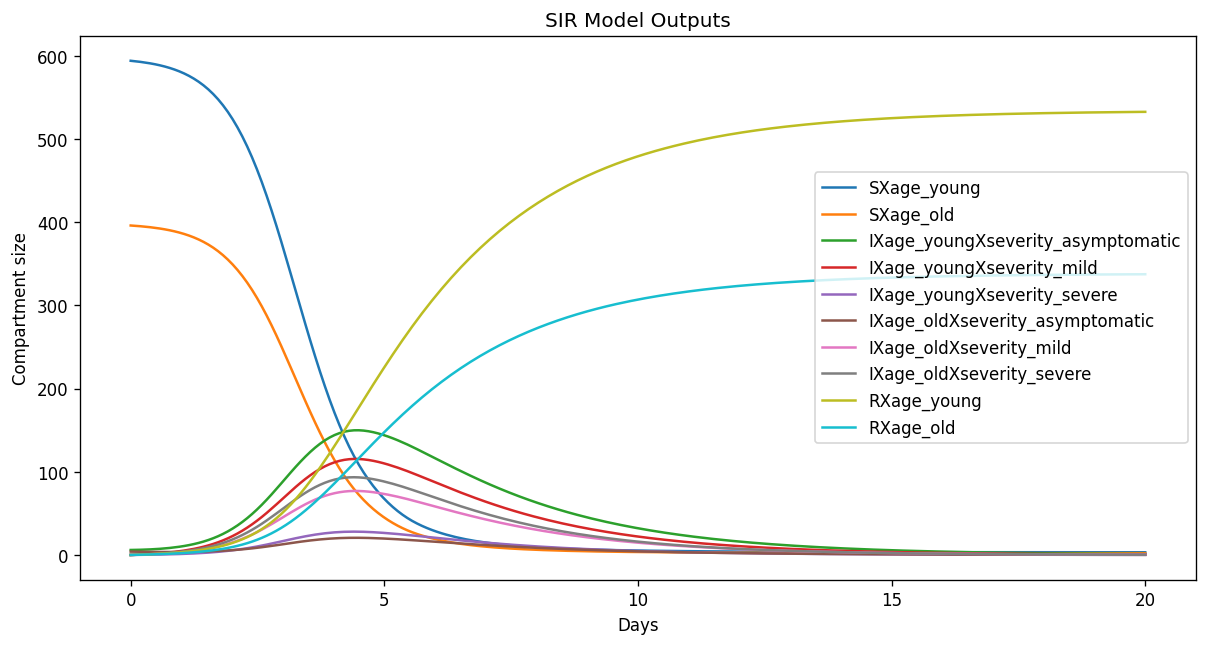

Compartment names: [SXage_young, SXage_old, IXage_youngXseverity_asymptomatic, IXage_youngXseverity_mild, IXage_youngXseverity_severe, IXage_oldXseverity_asymptomatic, IXage_oldXseverity_mild, IXage_oldXseverity_severe, RXage_young, RXage_old]
Initial values: [594.00 396.00 6.00 0.00 0.00 4.00 0.00 0.00 0.00 0.00]
Final values: [3.22 2.14 0.99 0.55 0.09 0.13 0.36 0.31 532.61 337.41]


In [9]:
from summer import Stratification, Multiply, Overwrite

### Age stratification

# Create a stratification named 'age', applying to all compartments,
# which splits the population into 'young' and 'old'.
strata = ["young", "old"]
age_strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])
age_strat.set_population_split({"young": 0.6, "old": 0.4})

### Disease severity stratification (depends on the age stratification)

# Create a stratification named 'severity', applying to the infectious, which
# splits that compartment into 'asymptomatic', 'mild' and 'severe'.
strata = ["asymptomatic", "mild", "severe"]
severity_strat = Stratification(name="severity", strata=strata, compartments=["I"])
severity_strat.set_population_split({"asymptomatic": 1.0, "mild": 0, "severe": 0})

# Add an adjustment to the 'infection' flow for young people
# where younger people tend towards asymptomatic infection
young_infection_adjustments = {
    "asymptomatic": Multiply(0.5),  # 50% of cases are asympt.
    "mild": Multiply(0.4),  # 40% of cases are mild.
    "severe": Multiply(0.1),  # 10% of cases are severe.
}
severity_strat.add_flow_adjustments(
    "infection",
    young_infection_adjustments,
    source_strata={'age': 'young'}  # Only apply this adjustment to flows of young people
)

# Add an adjustment to the 'infection' flow for old people
# where older people tend towards severe infection
old_infection_adjustments = {
    "asymptomatic": Multiply(0.1),  # 10% of cases are asympt.
    "mild": Multiply(0.4),  # 40% of cases are mild.
    "severe": Multiply(0.5),  # 50% of cases are severe.
}
severity_strat.add_flow_adjustments(
    "infection",
    old_infection_adjustments,
    source_strata={'age': 'old'}   # Only apply this adjustment to flows of old people
)

# Add an adjustment to the 'infection_death' flow (for all age groups)
severity_strat.add_flow_adjustments("infection_death", {
    "asymptomatic": Multiply(0.5),
    "mild": None,
    "severe": Multiply(1.5),
})

# Adjust infectiousness levels (for all age groups)
severity_strat.add_infectiousness_adjustments("I", {
    "asymptomatic": Multiply(0.5),
    "mild": None,
    "severe": Multiply(1.5),
})


# Build and run model with the stratifications we just defined
model = build_model()
# Apply age, then severity stratifications 
model.stratify_with(age_strat)
model.stratify_with(severity_strat)
model.run()
plot_compartments(model)